In [1]:
%matplotlib inline

import os

import gym
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

from models.vae import get_vae
from models.rnn import get_rnn

# Visualize VAE Recreation Car Racing

In [137]:
data_shape = (64, 64, 3)
latent_dim = 32
data_path = 'environments/carracing/data/1645901712.npz'
vae_checkpoint_path = 'environments/carracing/checkpoints/vae.h5'
num_images = 5
output_file_vae = 'carracing_vae.png'

In [138]:
vae = get_vae(data_shape, latent_dim)
vae.load_weights(vae_checkpoint_path)

In [139]:
obs = np.load(data_path)['obs'] / 255
np.random.shuffle(obs)
obs = obs[:num_images]
predictions = vae.predict(obs)

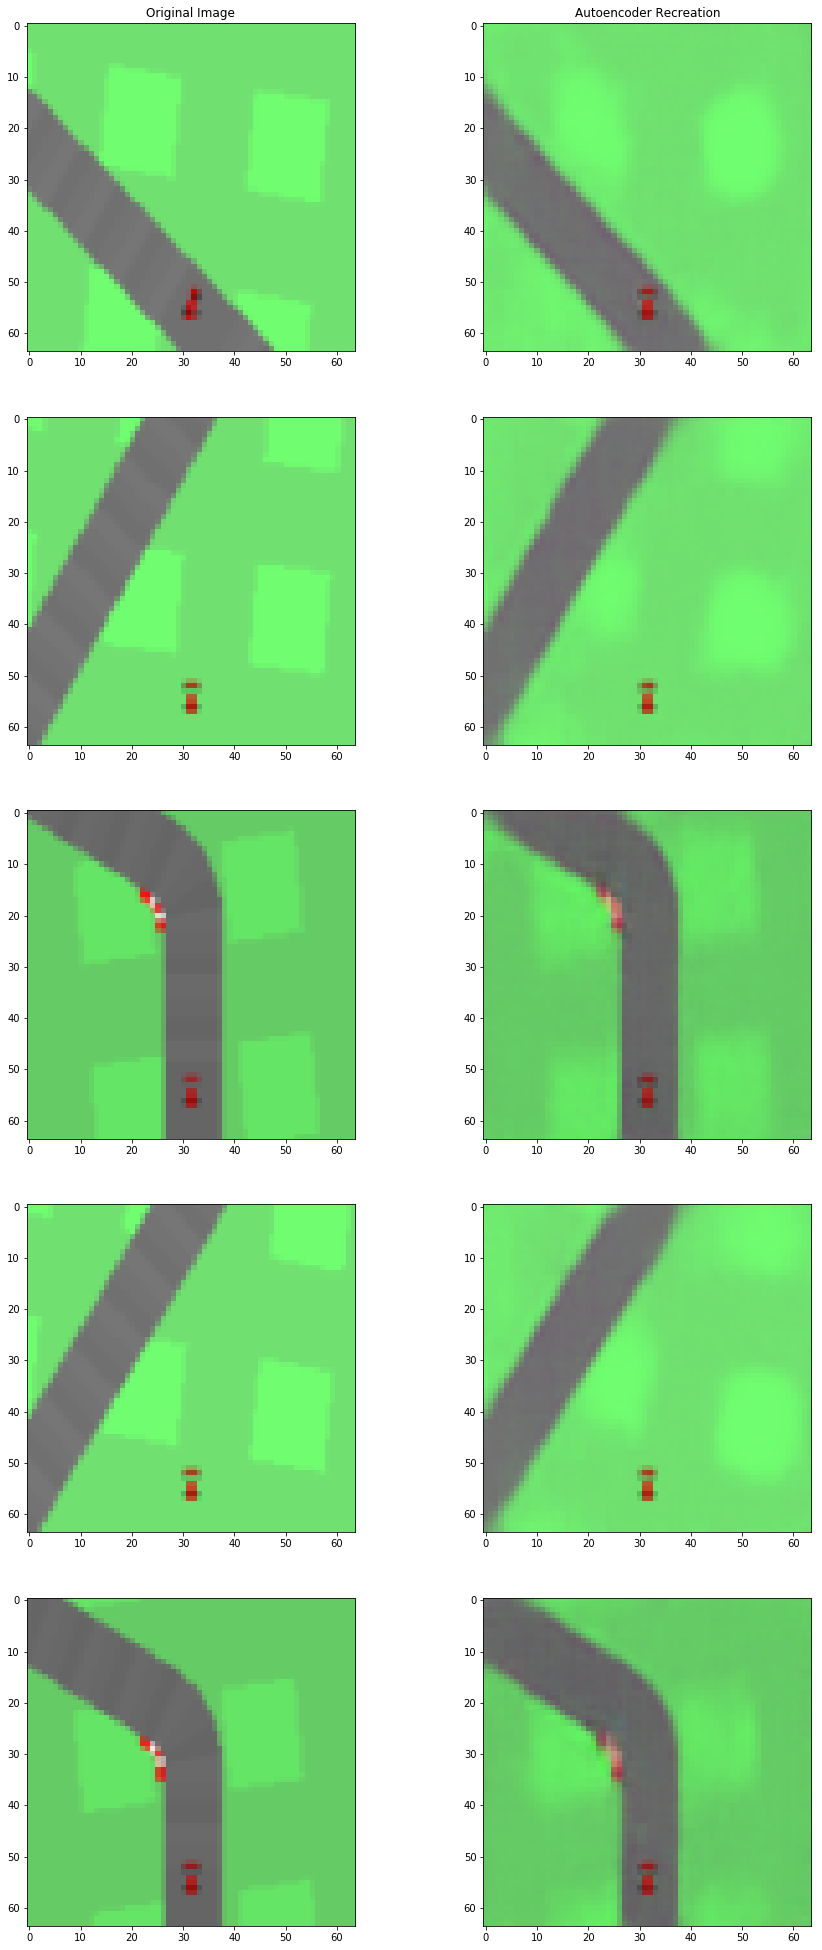

In [140]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Original Image')
axes[0][1].set_title('Autoencoder Recreation')
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_vae)

# Visualize RNN Prediction Car Racing

In [141]:
rnn_checkpoint_path = 'environments/carracing/checkpoints/rnn2.h5'
output_file_rnn = 'carracing_rnn.png'
offset = 300
num_images = 5
action_dim = 3
series_path = 'environments/carracing/data/series.npz'

In [142]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
decoder = Model(inputs=vae.get_layer('decoder').input,
                outputs=vae.get_layer('decoder').output)

In [143]:
rnn_train, rnn_infer = get_rnn((None, latent_dim + action_dim), output_sequence_width=latent_dim)
rnn_train.load_weights(rnn_checkpoint_path)

In [144]:
raw_data = np.load(series_path)
raw_z_true = raw_data['z']
raw_data_action = raw_data['action']

In [153]:
indices = np.random.randint(0, len(raw_z_true[0]) - 1, size=num_images + 1)

In [154]:
z_true = raw_z_true[0][indices + 1]
actions = raw_data_action[0][indices]

In [155]:
rnn_input = np.concatenate([z_true, actions], axis=-1)[:-1]
rnn_input = np.reshape(rnn_input, (-1, 1, latent_dim+action_dim))
z_pred = rnn_train.predict(rnn_input)

In [156]:
# Sample predictions
num_mixtures = 5
output_sequence_width = 32
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]
# Extract flattened variables
logpis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
sigmas_flat = np.exp(sigmas_flat)
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
logpis = np.reshape(logpis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Tempearture stuff
temperature = 0.05
logpistemp = np.copy(logpis)/temperature
logpistemp -= logpistemp.max()
pistemp = np.exp(logpistemp)
pistemp /= pistemp.sum(axis=2, keepdims=True)
pitemp = pistemp[:,0,:,:]
mu = mus[:,0,:,:]
sigma = sigmas[:,0,:,:]

/Users/rubenpurdy/envs/gym/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [157]:
def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [158]:
pi_idx = np.zeros((pitemp.shape[0], latent_dim))
chosen_mu = np.zeros((pitemp.shape[0], latent_dim))
chosen_sigma = np.zeros((pitemp.shape[0], latent_dim))
for i in range(pitemp.shape[0]):
    for j in range(32):
        idx = get_pi_idx(np.random.rand(), pitemp[i][:,j])
        pi_idx[i,j] = idx
        chosen_mu[i,j] = mu[i][idx][j]
        chosen_sigma[i,j] = sigma[i][idx][j]

rand_gaussian = np.random.normal(size=(pitemp.shape[0], latent_dim))*np.sqrt(temperature)
next_z = chosen_mu+chosen_sigma*rand_gaussian

error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sampling ensemble
error with sam

In [159]:
predictions = decoder.predict(next_z)
predictions_real = decoder.predict(z_true)

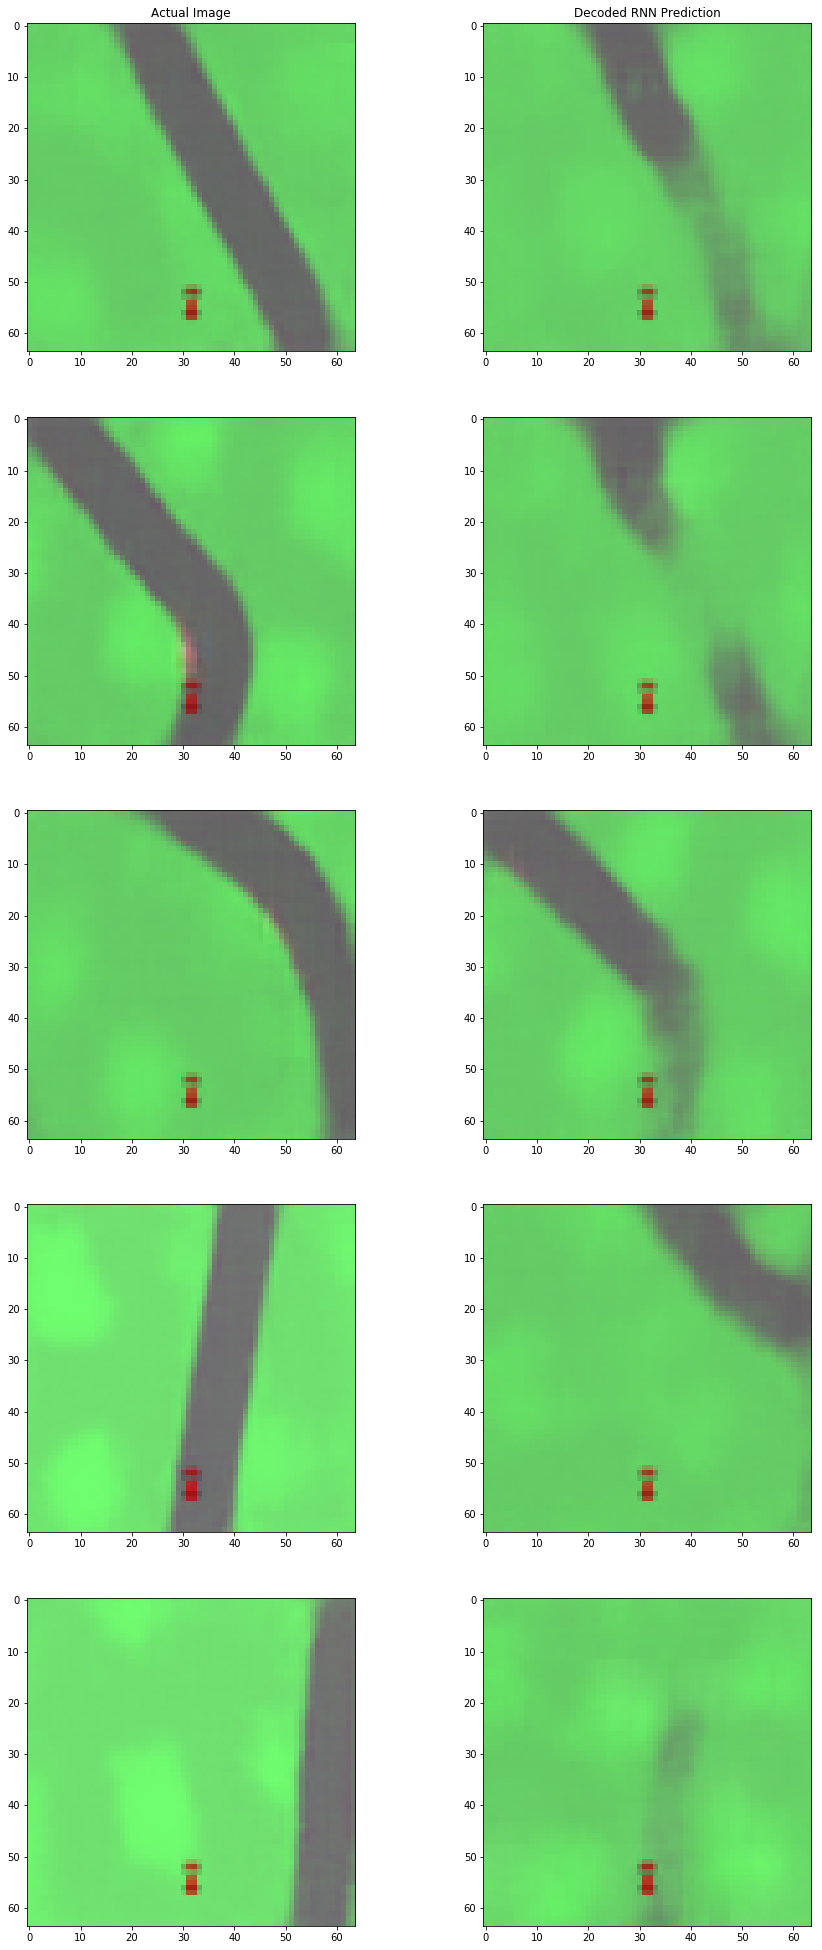

In [160]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Actual Image')
axes[0][1].set_title('Decoded RNN Prediction')
for ax, im, gen in zip(axes, predictions_real[1:], predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_rnn)

# Visualize VAE Recreation Skiing

#### Set these variables to indicate which autoencoder to visualize

In [161]:
data_shape = (144, 144, 3)
latent_dim = 64
data_path = 'environments/skiing/data/1127041855.npz'
vae_checkpoint_path = 'environments/skiing/checkpoints/vae.h5'
num_images = 5
output_file_vae = 'skiing_vae.png'

In [162]:
vae = get_vae(data_shape, latent_dim,
                  filters=[16, 32, 64, 128, 256],
                  kernels=[4, 4, 4, 4, 4],
                  strides=[2, 2, 2, 2, 2],
                  deconv_filters=[256, 128, 64, 32, 16, 3],
                  deconv_kernels=[2, 5, 4, 4, 5, 4],
                  deconv_strides=[2, 2, 2, 2, 2, 2])
vae.load_weights(vae_checkpoint_path)

In [163]:
obs = np.load(data_path)['obs'] / 255
np.random.shuffle(obs)
obs = obs[:num_images]
predictions = vae.predict(obs)

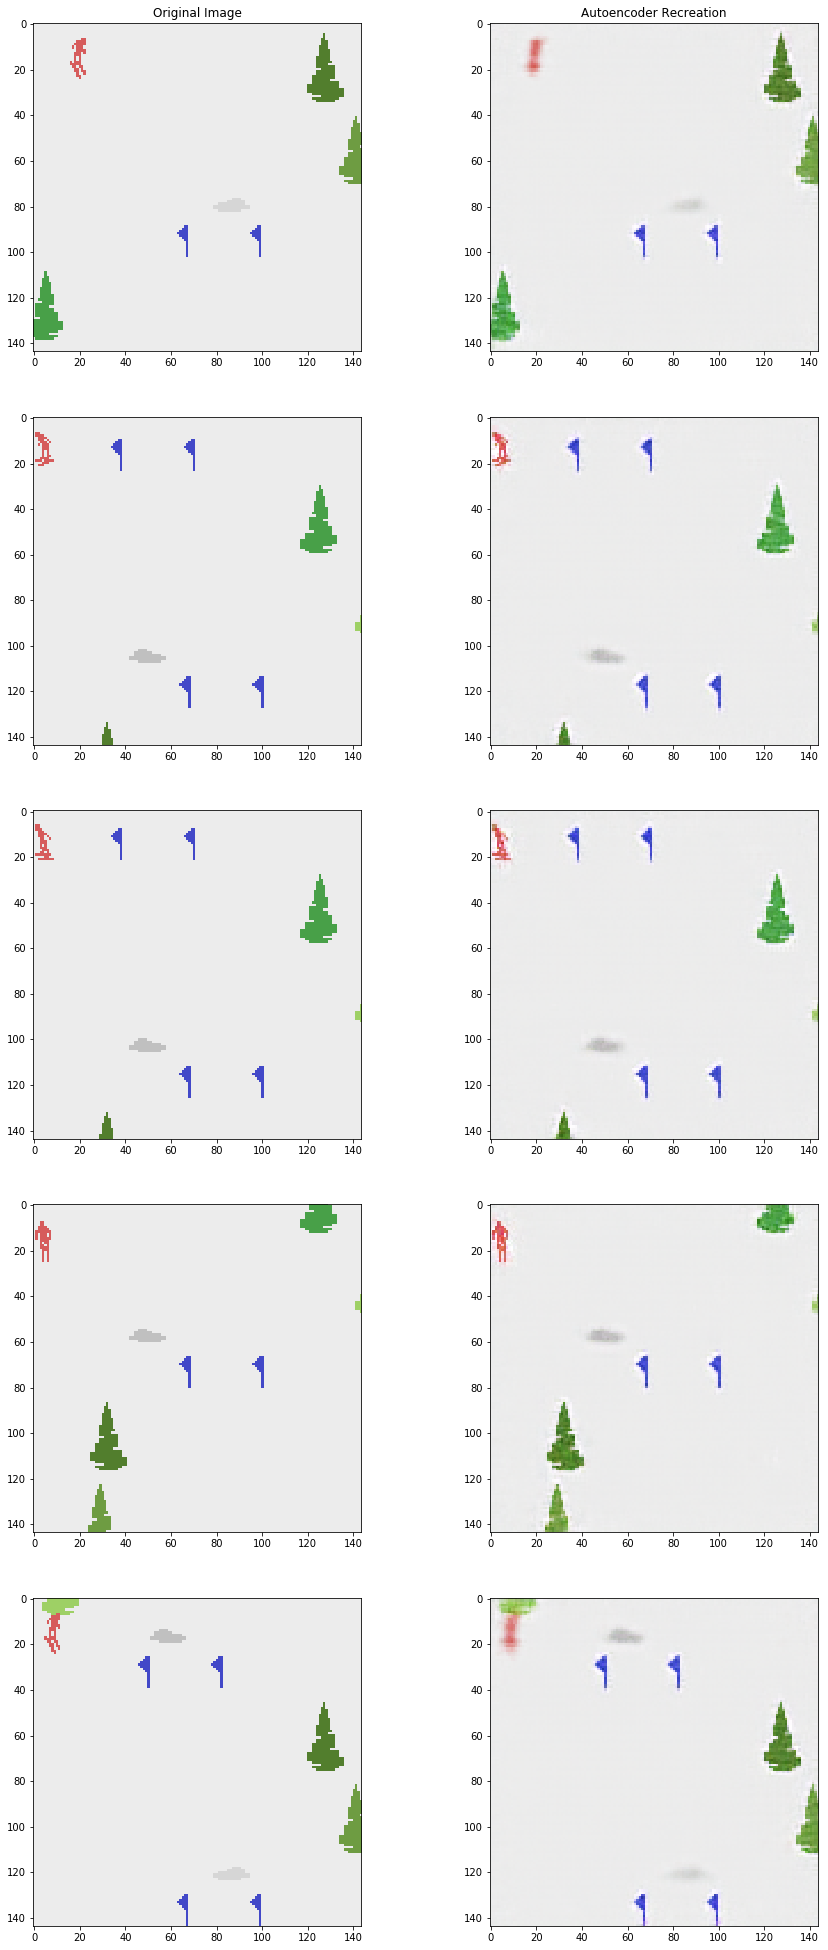

In [164]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Original Image')
axes[0][1].set_title('Autoencoder Recreation')
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_vae)

# Visualize RNN Prediction

#### Assuming correct VAE variables were set above, just set these to indicate which RNN to use

In [165]:
rnn_checkpoint_path = 'environments/skiing/checkpoints/rnn.h5'
output_file_rnn = 'skiing_rnn.png'
offset = 300
num_images = 5
action_dim = 3
series_path = 'environments/skiing/data/series.npz'

In [166]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
decoder = Model(inputs=vae.get_layer('decoder').input,
                outputs=vae.get_layer('decoder').output)

In [167]:
rnn_train, rnn_infer = get_rnn((None, latent_dim + action_dim), output_sequence_width=latent_dim)
rnn_train.load_weights(rnn_checkpoint_path)

In [169]:
raw_data = np.load(series_path)
raw_z_true = raw_data['z']
raw_data_action = raw_data['action']

In [170]:
z_true = raw_z_true[0][offset:offset+num_images+1]
actions = raw_data_action[0][offset:offset+num_images+1]

In [171]:
# z_true = encoder.predict(obs)[-1]
rnn_input = np.concatenate([z_true, actions], axis=-1)[:-1]
rnn_input = np.reshape(rnn_input, (-1, 1, latent_dim+action_dim))
z_pred = rnn_train.predict(rnn_input)

In [177]:
# Sample predictions
num_mixtures = 5
output_sequence_width = latent_dim
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]
# Extract flattened variables
logpis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
sigmas_flat = np.exp(sigmas_flat)
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
logpis = np.reshape(logpis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Tempearture stuff
temperature = 0.05
logpistemp = np.copy(logpis)/temperature
logpistemp -= logpistemp.max()
pistemp = np.exp(logpistemp)
pistemp /= pistemp.sum(axis=2, keepdims=True)
pitemp = pistemp[:,0,:,:]
mu = mus[:,0,:,:]
sigma = sigmas[:,0,:,:]

In [178]:
def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [179]:
pi_idx = np.zeros((pitemp.shape[0], latent_dim))
chosen_mu = np.zeros((pitemp.shape[0], latent_dim))
chosen_sigma = np.zeros((pitemp.shape[0], latent_dim))
for i in range(pitemp.shape[0]):
    for j in range(32):
        idx = get_pi_idx(np.random.rand(), pitemp[i][:,j])
        pi_idx[i,j] = idx
        chosen_mu[i,j] = mu[i][idx][j]
        chosen_sigma[i,j] = sigma[i][idx][j]

rand_gaussian = np.random.normal(size=(pitemp.shape[0], latent_dim))*np.sqrt(temperature)
next_z = chosen_mu+chosen_sigma*rand_gaussian

In [180]:
predictions = decoder.predict(next_z)
predictions_real = decoder.predict(z_true)

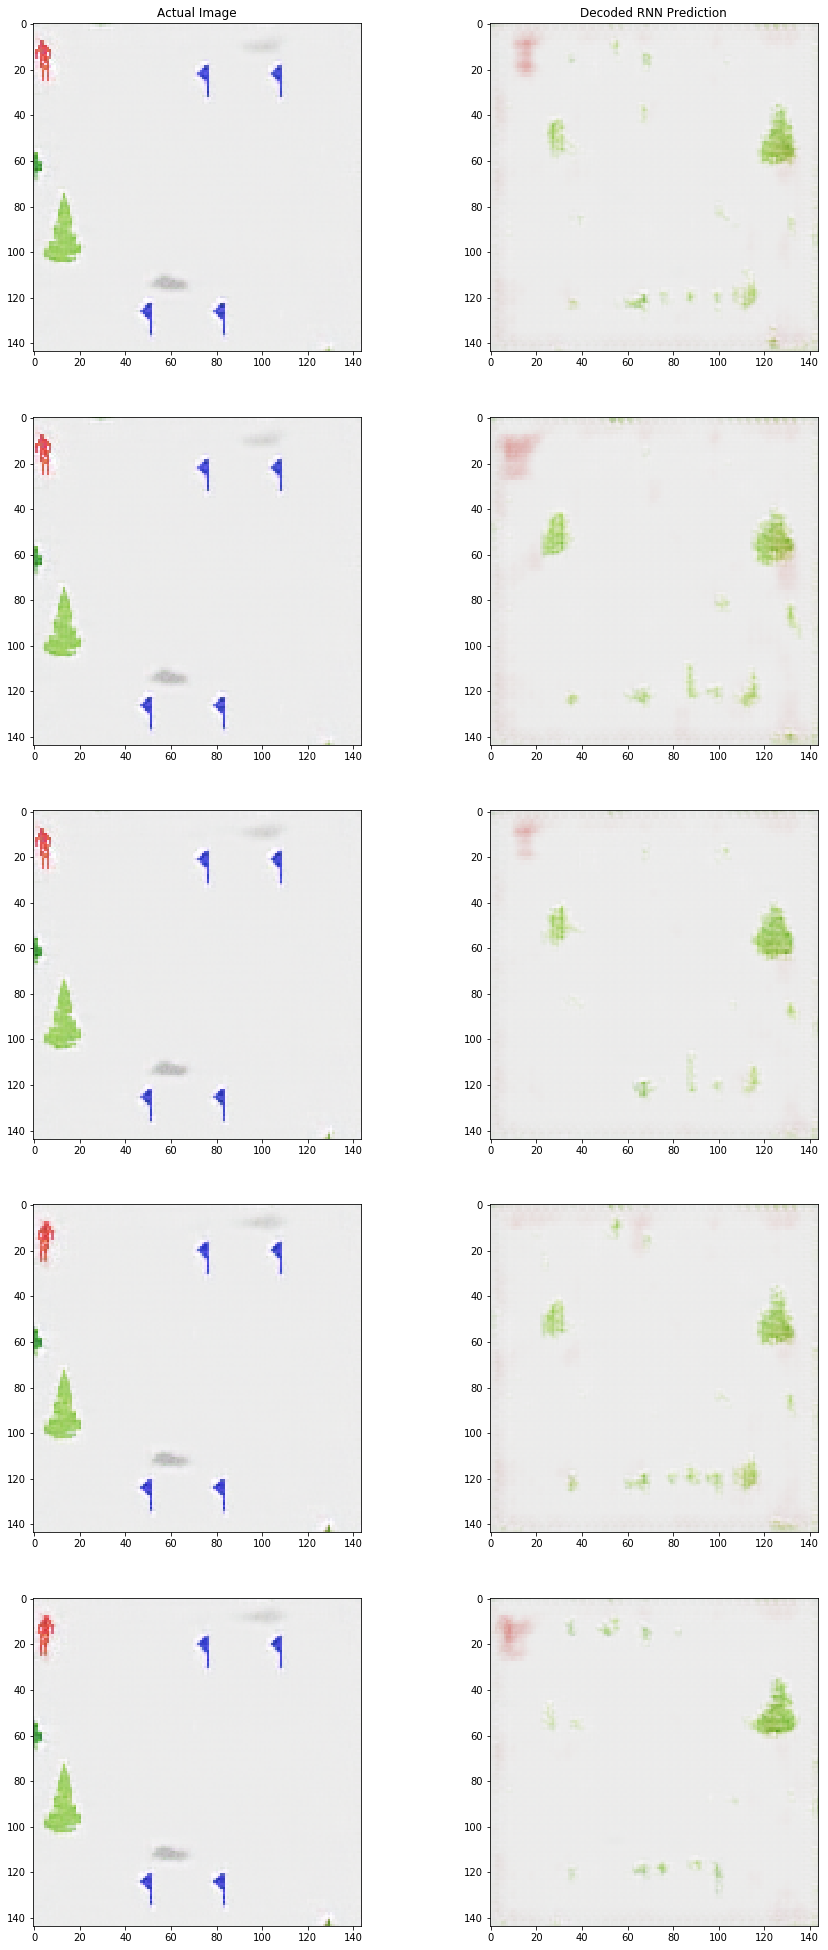

In [181]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Actual Image')
axes[0][1].set_title('Decoded RNN Prediction')
for ax, im, gen in zip(axes, predictions_real[1:], predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_rnn)